## Prepare your relation file

Prepare your relation file and specify the path in the following cell. The relation file should be a csv/tsv file and the first line should be the header. For the format of the entity & relation file, please refer to the [README](../graph_data/README.md). If you want to build your own entity & relation file, please refer to the [KG README](../graph_data/KG_README.md) for more details.

We assume that the relation file is named as `knowledge_graph.tsv`, the entity file is named as `annotated_entities.tsv`, and are located in the `datasets` directory or `you can specify the path in the following cell`.

In [1]:
import os

datadir = os.path.join(os.path.dirname(os.getcwd()), "datasets", "biomedgps-v2-20231223")

entity_file = os.path.join(datadir, "annotated_entities.tsv")
relation_file = os.path.join(datadir, "knowledge_graph.tsv")

### Install Dependencies

We defined all related functions in `lib/graph.py` module. Before doing the graph analysis, we need to import the module. In addition, we assume that you have followed the instructions in the [README](../README.md) file and have installed all the required dependencies.

In [2]:
import os
import sys

libdir = os.path.join(os.path.dirname(os.getcwd()), "lib")
sys.path.append(libdir)

from graph import (
    biomedgps2stat,
    make_wide_format,
    transposed_array,
    snake_case,
    gen_layout,
)

libdir = os.path.join(os.path.dirname(os.getcwd()), "embeddings/scripts/")
sys.path.append(libdir)

from lib import get_color


### Prepare the data

In [3]:
import pandas as pd

entities = pd.read_csv(entity_file, sep="\t")
relations = pd.read_csv(relation_file, sep="\t")
node_stat, edge_stat, real_node_stat = biomedgps2stat(entities, relations, enable_stat_real_entities=True)

# Merge two columns: start_entity_type and end_entity_type, the string format is "start_entity_type:end_entity_type"
edge_stat["simple_relation_type"] = (
    edge_stat["start_entity_type"] + ":" + edge_stat["end_entity_type"]
)

# start_entity_type:end_entity_type may be same as end_entity_type:start_entity_type, so we need to merge them
edge_stat["simple_relation_type"] = edge_stat["simple_relation_type"].apply(
    lambda x: ":".join(sorted(x.split(":")))
)

edge_stat.to_csv(os.path.join(datadir, "edge_stat.tsv"), sep="\t", index=False)
node_stat.to_csv(os.path.join(datadir, "node_stat.tsv"), sep="\t", index=False)
real_node_stat.to_csv(os.path.join(datadir, "real_node_stat.tsv"), sep="\t", index=False)

/var/folders/4s/d4nr1sg91ps1k3qz00h28w_r0000gp/T/ipykernel_24745/387943002.py:3: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  entities = pd.read_csv(entity_file, sep="\t")
/var/folders/4s/d4nr1sg91ps1k3qz00h28w_r0000gp/T/ipykernel_24745/387943002.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  relations = pd.read_csv(relation_file, sep="\t")


In [4]:
node_stat

,entity_type,resource,entity_count
0,Anatomy,MESH,1315
1,Anatomy,UBERON,15822
2,BiologicalProcess,GO,30571
3,BiologicalProcess,Hetionet,387
4,CellularComponent,GO,4485
5,CellularComponent,Hetionet,32
6,Compound,DrugBank,267869
7,Compound,MESH,167
8,Disease,DOID,1
9,Disease,MESH,3518


In [5]:
edge_stat

,relation_type,start_entity_type,end_entity_type,resource,relation_count,simple_relation_type
0,DGIDB::ACTIVATOR::Gene:Compound,Gene,Compound,DGIDB,219,Compound:Gene
1,DGIDB::AGONIST::Gene:Compound,Gene,Compound,DGIDB,1721,Compound:Gene
2,DGIDB::ALLOSTERIC MODULATOR::Gene:Compound,Gene,Compound,CustomKB,1,Compound:Gene
3,DGIDB::ALLOSTERIC MODULATOR::Gene:Compound,Gene,Compound,DGIDB,168,Compound:Gene
4,DGIDB::ANTAGONIST::Gene:Compound,Gene,Compound,DGIDB,1617,Compound:Gene
...,...,...,...,...,...,...
187,treats,Compound,BiologicalProcess,CustomKB,1,BiologicalProcess:Compound
188,treats,Compound,Disease,CustomKB,2,Compound:Disease
189,treats,Compound,Pathway,CustomKB,1,Compound:Pathway
190,treats,Compound,Symptom,CustomKB,1,Compound:Symptom


In [6]:
real_node_stat

,entity_type,resource,entity_count
0,Anatomy,MESH,7
1,Anatomy,UBERON,400
2,BiologicalProcess,GO,11009
3,BiologicalProcess,Hetionet,387
4,CellularComponent,GO,1363
5,CellularComponent,Hetionet,32
6,Compound,DrugBank,15500
7,Compound,MESH,25
8,Disease,MESH,1514
9,Disease,MONDO,4014


### Chart 1: Number of nodes and edges in the graph

In [7]:
import plotly.graph_objects as go
import plotly.express as px

node_count = node_stat["entity_count"].sum()
edge_count = edge_stat["relation_count"].sum()
real_node_count = real_node_stat["entity_count"].sum()

fig = go.Figure(
    data=[
        go.Pie(
            labels=["Node Count", "Edge Count", "Real Node Count"],
            values=[node_count, edge_count, real_node_count],
            textinfo="value",
        )
    ]
)
fig.update_layout(**gen_layout("Total Count", "Type", "Count", True))
fig.show()

### Chart 2: Number of nodes for each entity type

In [8]:
chart2_data = node_stat.groupby(["resource", "entity_type"]).sum().reset_index()
fig2 = px.bar(chart2_data, x="entity_type", y="entity_count", color="resource", barmode="stack")
fig2.update_layout(**gen_layout("Node Count", "Node Type", "Count", True))
fig2.show()

### Chart 3: Number of nodes for each resource

In [9]:
chart3_data = node_stat.groupby(["entity_type"]).sum().reset_index()
fig3 = px.bar(
    chart3_data, x="resource", y="entity_count", color="entity_type", barmode="stack"
)
fig3.update_layout(**gen_layout("Node Count", "Resource", "Count", True))
fig3.show()

### Chart 4: Number of relations for each relation type

In [10]:
chart4_data = edge_stat.groupby(["resource", "simple_relation_type"]).sum().reset_index()
fig4 = px.bar(
    chart4_data,
    x="simple_relation_type",
    y="relation_count",
    color="resource",
    barmode="stack",
)
fig4.update_layout(**gen_layout("Edge Count", "Relation Type", "Count", True))
fig4.show()

### Chart 5: Number of relations for each resource

In [11]:
selected_edge_stat = edge_stat[["resource", "simple_relation_type", "relation_count"]]
chart5_data = selected_edge_stat.groupby(["simple_relation_type", "resource"]).sum().reset_index()
fig5 = px.bar(chart5_data, x="resource", y="relation_count", color="simple_relation_type", barmode="stack")
fig5.update_layout(**gen_layout("Edge Count", "Resource", "Count", True))
fig5.show()

### Table 1: Number of nodes

In [12]:
import plotly.graph_objects as go

header_color = "grey"
row_even_color = "lightgrey"
row_odd_color = "white"

node_stat_dicts = node_stat.to_dict("records")
data = make_wide_format(node_stat_dicts, "entity_type", "resource", "entity_count")
columns = list(set([item["resource"] for item in node_stat_dicts]))
cell_values = transposed_array(
    [
        [item["entity_type"]] + [item.get(snake_case(column), 0) for column in columns]
        for item in data
    ]
)

row_num = len(cell_values[0])
colors = [row_even_color if i % 2 == 0 else row_odd_color for i in range(row_num)]

table = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Node Type"] + columns,
                align="center",
                line=dict(width=1, color="black"),
                fill=dict(color=header_color),
                font=dict(family="Arial", size=12, color="white"),
            ),
            cells=dict(
                values=cell_values,
                align="center",
                line=dict(color="black", width=1),
                fill=dict(color=[colors]),
                font=dict(family="Arial", size=11, color="black"),
                height=30,
            ),
        )
    ]
)

table.update_layout(title="Node Count")
table.show()

### Table 2: Number of relations

In [13]:
import plotly.graph_objects as go

header_color = "grey"
row_even_color = "lightgrey"
row_odd_color = "white"

grouped_edge_stat = (
    edge_stat.groupby(["simple_relation_type", "resource"]).sum().reset_index()
)
edge_stat_dicts = grouped_edge_stat.to_dict("records")
data = make_wide_format(
    edge_stat_dicts, "simple_relation_type", "resource", "relation_count"
)
columns = list(set([item["resource"] for item in edge_stat_dicts]))
cell_values = transposed_array(
    [
        [item["simple_relation_type"]]
        + [item.get(snake_case(column), 0) for column in columns]
        for item in data
    ]
)

row_num = len(cell_values[0])
colors = [row_even_color if i % 2 == 0 else row_odd_color for i in range(row_num)]

table2 = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Relation Type"] + columns,
                align="center",
                line=dict(width=1, color="black"),
                fill=dict(color=header_color),
                font=dict(family="Arial", size=12, color="white"),
            ),
            cells=dict(
                values=cell_values,
                align="center",
                line=dict(color="black", width=1),
                fill=dict(color=[colors]),
                font=dict(family="Arial", size=11, color="black"),
                height=30,
            ),
        )
    ]
)

table2.update_layout(title="Edge Count")
table2.show()

### Pie Chart 1: Distribution of Entity Types

In [14]:
import plotly.express as px

# 准备饼图数据
temp_node_stat = node_stat
# 准备饼图数据
entity_types = temp_node_stat["entity_type"]
entity_counts = temp_node_stat["entity_count"]

# 绘制饼图
fig_pie = px.pie(
    temp_node_stat,
    names=entity_types,
    values=entity_counts,
    title="Distribution of Entity Types",
)

# 修改饼图的标签和显示内容
fig_pie.update_traces(
    textinfo="label+value",  # 显示实体类型标签和总数目
    hovertemplate="%{label}: %{value} nodes",  # 悬浮时显示实体类型和总数
    textposition="outside",  # 实体类型标签显示在饼图外部
    pull=[
        0.1 if entity == "Metabolite" else 0 for entity in entity_types
    ],  # 把较小的部分拉出来
)

# 调整布局，增加图形尺寸
fig_pie.update_layout(
    margin=dict(t=0, b=0, l=0, r=0),  # 调整图的边距
    height=700,  # 增加图形高度
    width=1000,  # 增加图形宽度
)

# 显示饼图
fig_pie.show()

### Pie Chart 2: Distribution of Node Types in Real Graph

In [15]:
import plotly.express as px

# 准备饼图数据
temp_node_stat = real_node_stat

# 准备饼图数据
entity_types = temp_node_stat["entity_type"]
entity_counts = temp_node_stat["entity_count"]

# 绘制饼图
fig_pie = px.pie(
    temp_node_stat,
    names=entity_types,
    values=entity_counts,
    title="Distribution of Entity Types",
)

# 修改饼图的标签和显示内容
fig_pie.update_traces(
    textinfo="label+value",  # 显示实体类型标签和总数目
    hovertemplate="%{label}: %{value} nodes",  # 悬浮时显示实体类型和总数
    textposition="outside",  # 实体类型标签显示在饼图外部
    pull=[
        0.1 if entity == "Metabolite" else 0 for entity in entity_types
    ],  # 把较小的部分拉出来
)

# 调整布局，增加图形尺寸
fig_pie.update_layout(
    margin=dict(t=0, b=0, l=0, r=0),  # 调整图的边距
    height=700,  # 增加图形高度
    width=1000,  # 增加图形宽度
)

# 显示饼图
fig_pie.show()

### Pie Chart 3: Distribution of Relation Types in Real Graph

In [20]:
# 颜色设置
header_color = "#404040"
row_even_color = "#f5f5f5"
row_odd_color = "#e0e0e0"

# 按 simple_relation_type 和 relation_type 分组并计算每个关系的数量
grouped_edge_stat = (
    edge_stat[edge_stat["relation_count"] > 100].groupby(["simple_relation_type", "relation_type"]).sum().reset_index()
)

# Order by the simple_relation_type and relation_count
grouped_edge_stat = grouped_edge_stat.sort_values(
    by=["simple_relation_type", "relation_count"], ascending=[True, False]
)

# 准备表格数据
index = grouped_edge_stat.index.tolist()
relation_types = grouped_edge_stat["relation_type"].tolist()
simple_relation_types = grouped_edge_stat["simple_relation_type"].tolist()
relation_counts = grouped_edge_stat["relation_count"].tolist()

# 设置表格的行数
row_num = len(relation_types)

# 设置每一行的背景色，奇偶行不同
colors = [row_even_color if i % 2 == 0 else row_odd_color for i in range(row_num)]

# 生成合并的表格
table = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["#", "Simple Relation Type", "Relation Type", "Count"],
                align="center",
                line=dict(width=1, color="black"),
                fill=dict(color=header_color),
                font=dict(family="Arial", size=14, color="white"),
            ),
            cells=dict(
                values=[index, simple_relation_types, relation_types, relation_counts],
                align="center",
                line=dict(color="black", width=1),
                fill=dict(color=[colors]),
                font=dict(family="Arial", size=14, color="black"),
                height=30,
            ),
        )
    ]
)

# 设置表格标题
table.update_layout(title="Relation Type and Count Table")

# Show all the rows, don't need to scroll
table.update_layout(height=1600)

table.write_image(os.path.join(datadir, "relation_type_and_count_table.png"), height = 3200, width = 1600)

# 显示表格
table.show()

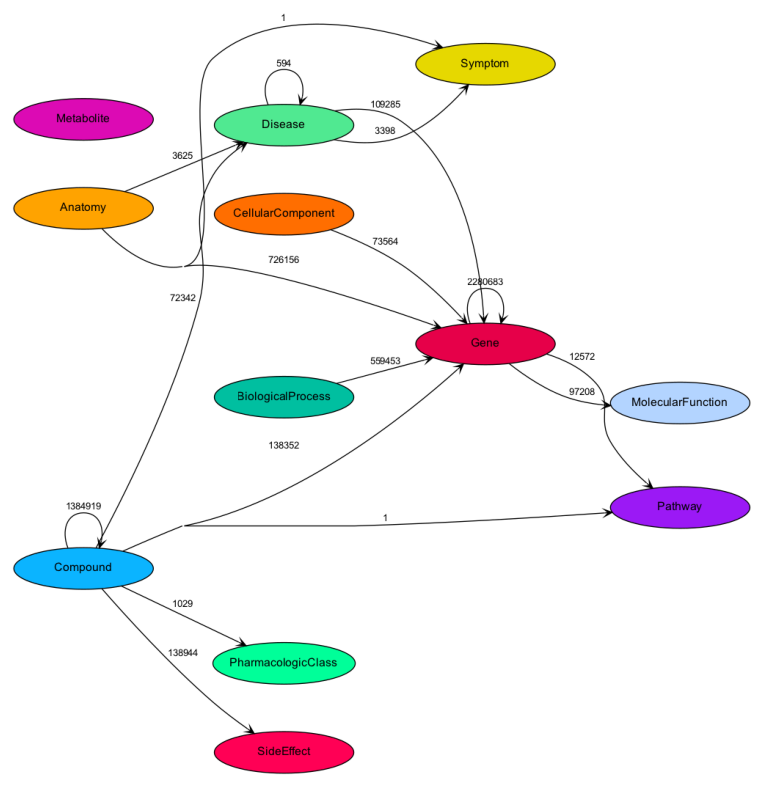

In [17]:
# Using regex to filter out the rows with the relation type not matching the pattern "\w+::\w+::\w+:\w+"
filtered_edge_stat = edge_stat[edge_stat["relation_type"].str.contains(r".*::.*::.*:.*")]

# Group by simple_relation_type and sum the relation_count
merged_edge_stat = (
    filtered_edge_stat.groupby(["simple_relation_type"])["relation_count"]
    .sum()
    .reset_index()
)
merged_edge_stat["start_entity_type"] = merged_edge_stat["simple_relation_type"].apply(lambda x: x.split(":")[0])
merged_edge_stat["end_entity_type"] = merged_edge_stat["simple_relation_type"].apply(lambda x: x.split(":")[1])

import pygraphviz as pgv
import matplotlib.pyplot as plt
import PIL.Image as Image

# 创建有向图
G = pgv.AGraph(strict=False, directed=True)

# 添加节点，定义颜色
for entity_type in node_stat["entity_type"].unique():
    G.add_node(
        entity_type,
        style="filled",
        fillcolor=get_color(entity_type),
        fontsize=12,
        fontname="Arial",
        shape="ellipse",
        width=2.0,
        height=0.6,
    )

# 添加边并定义关系标签和数量
for _, edge in merged_edge_stat.iterrows():
    G.add_edge(
        edge["start_entity_type"],
        edge["end_entity_type"],
        label=edge["relation_count"],
        fontsize=10,
        fontname="Arial",
        dir="forward",
        arrowsize=0.8,
        penwidth=1.0,
        len=0.5,  # 减小边的长度
        labeldistance=1.1,
        labelangle=-25,
        arrowhead="vee",
    )

# 设置图的整体属性
G.graph_attr.update(
    {
        "rankdir": "LR",
        "splines": "spline",
        "overlap": "false",
        "sep": "+3,3",  # 减小间隔
        "nodesep": 0.5,  # 减小同层节点间距
        "ranksep": 0.4,  # 减小层间距
        "ratio": "1",  # 调整比例使图形更扁
        "size": "14,3.5",  # 略微减小高度
        "concentrate": "true",
        "ordering": "out",  # 优化边的排序
    }
)

# 设置默认的节点和边属性
# G.node_attr.update({"margin": "0.12"})
# G.edge_attr.update({"weight": "1.0"})

# 设置图的布局为dot模式，并导出为高分辨率图片
G.layout(prog="dot")
G.draw("/tmp/network_graph_high_res.png", prog="dot", args="-Gdpi=300")

# 显示图片
img = Image.open("/tmp/network_graph_high_res.png")
plt.figure(figsize=(10, 10))  # 调整显示比例
plt.imshow(img)
plt.axis("off")
plt.show()